# TEST ANGULAR POWER SPECTRA

This test uses the matter power spectrum from cosmosis and the filters using the lensing efficiency from Tessore & Harrison 2020. The result should match with cosmosis des year1.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import interp1d
from astropy.cosmology import FlatLambdaCDM

In [56]:
plt.rcParams.update({
    'text.usetex': False,
    'font.family': 'serif',
    'legend.frameon': False,
    'legend.handlelength': 1.5,
})

In [2]:
TINY = np.finfo(0.).tiny

## 1. Load CosmoSIS quantities

* Metadata

In [67]:
nbin = 4

In [68]:
bin_a, bin_b = np.tril_indices(nbin)
bin_a += 1
bin_b += 1

* Cosmology

In [44]:
cosmo = {}
with open('des-y1-test/cosmological_parameters/values.txt') as cosmo_values:
    for line in cosmo_values:
        if line:
            key, val = line.partition('=')[::2]
            cosmo[key.strip()] = float(val)

In [108]:
cosmo_astropy = FlatLambdaCDM(H0=cosmo['hubble'], Ob0=cosmo['omega_b'], Om0= cosmo['omega_m'], Tcmb0=2.7)

* Distance functions

In [47]:
zdM = np.loadtxt('des-y1-test/distances/z.txt')
dM = np.loadtxt('des-y1-test/distances/d_m.txt')

* Matter power spectrum

In [53]:
zp = np.loadtxt('des-y1-test/matter_power_nl/z.txt')
k_h = np.loadtxt('des-y1-test/matter_power_nl/k_h.txt')
p_h = np.loadtxt('des-y1-test/matter_power_nl/p_k.txt')

In [49]:
xp = np.interp(zp, zdM, dM)

In [50]:
k0, kf = k_h[0]*(cosmo['hubble']/100), k_h[-1]*(cosmo['hubble']/100)

In [54]:
k_h2 = np.logspace(np.log10(k0), np.log10(kf), 1024)
p_h2 = np.exp([np.interp(np.log(k_h2), np.log(k_h), np.log(p)) for p in p_h])

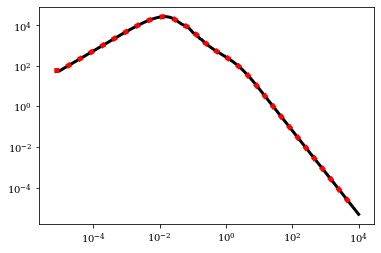

In [57]:
plt.loglog(k_h, p_h[0], '-k', lw=3)
plt.loglog(k_h2, p_h2[0], ':r', lw=5)
plt.show()

In [58]:
k = k_h2*cosmo['h0']
p = p_h2*cosmo['h0']**(-3)

In [59]:
p_geom = np.sqrt(p[:, None]*p[None, :])

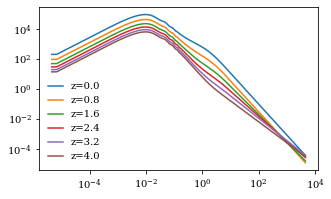

In [60]:
plt.figure(figsize=(5,3))
for z, pz in zip(zp[::20], p[::20]):
    plt.loglog(k, pz, label='z={}'.format(z))
plt.legend()
plt.show()

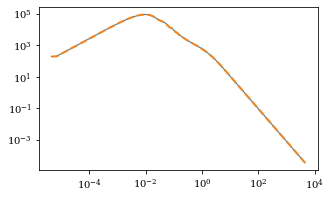

In [66]:
plt.figure(figsize=(5,3))
plt.loglog(k, p[0], lw=1)
plt.loglog(k, p_geom[0][0], '--',lw=2)
plt.show()

* Angula power spectrum

In [69]:
l_csis_ = np.loadtxt('des-y1-test/shear_cl/ell.txt')
cl_csis_ = [np.loadtxt('des-y1-test/shear_cl/bin_%d_%d.txt' % bins) for bins in zip(bin_a, bin_b)]

In [70]:
l_csis = np.arange(1, 100000.1, 1)
cl_csis = [np.interp(np.log(l_csis), np.log(l_csis_), cl) for cl in cl_csis_]

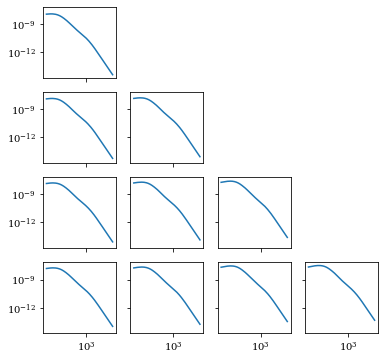

In [72]:
fig, axes = plt.subplots(4, 4, figsize=(6, 6), sharex=True, sharey=True)

for ax in axes.ravel():
    ax.axis('off')

for a, b, cl in zip(bin_a, bin_b, cl_csis):
    ax = axes[a-1, b-1]
    ax.axis('on')
    ax.loglog(l_csis, cl)

# fig.tight_layout(pad=0.5)

plt.show()

## 2. The correlation function

In [73]:
import sys
sys.path.append("../../corfu")
import corfu

In [74]:
theta = np.logspace(-4, np.log10(np.pi), 1024)

In [75]:
r_limb, xi_limb = corfu.ptoxi(k, p, q=0, limber=True)
r_geom, xi_geom = corfu.ptoxi(k, p_geom, q=0)

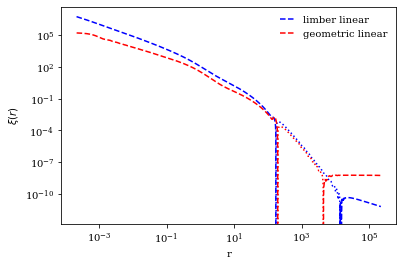

In [76]:
plt.figure(figsize=(6,4))
plt.loglog(r_limb, +xi_limb[0], '--b', label='limber linear')
plt.loglog(r_limb, -xi_limb[0], ':b')
plt.loglog(r_geom, +xi_geom[0,0], '--r', label='geometric linear')
plt.loglog(r_geom, -xi_geom[0,0], ':r')

plt.legend()
plt.xlabel('r')
plt.ylabel(r'$\xi(r)$')
plt.show()

## 3. Lensing filters

In [77]:
sys.path.append("../lensing")
from lens_filter import parametric_lensing_efficiency, redshift_distribution_galaxies, filter_galaxy_clustering, lensing_efficiency, filter_convergence, filter_shear

* Redshift distribution of galaxies

In [81]:
zn = np.loadtxt('des-y1-test/nz_source/z.txt')
nz = [np.loadtxt('des-y1-test/nz_source/bin_%d.txt' % i) for i in range(1, nbin+1)]

In [117]:
xf = np.interp(zn, zdM, dM)

* Lensing efficiency

In [119]:
q = [lensing_efficiency(xf, zn, n) for n in nz]

* Convergence

In [120]:
fc = [filter_convergence(xf, zn, qq, cosmo_astropy) for qq in q]

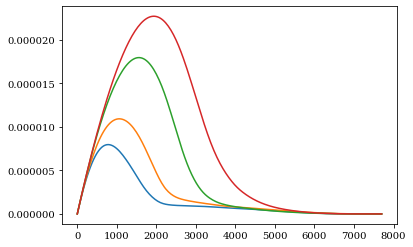

In [121]:
for qq in fc:
    plt.plot(xf, qq)
plt.show()

* Shear

In [122]:
# fs1 = filter_shear(xf, zf, q1, cosmo_astropy)
fs = [filter_shear(xf, zn, qq, cosmo_astropy) for qq in q]

../lensing/lens_filter.py:217: RuntimeWarning: divide by zero encountered in true_divide
  return factor.value * (1.0 + zx) * lens_efficiency / x


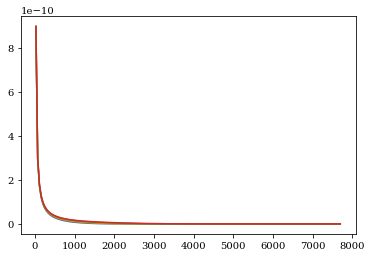

In [123]:
for qq in fs:
    plt.plot(xf, qq)
plt.show()

## 4. Angular correlation function

In [112]:
theta = np.logspace(-3, np.log10(np.pi), 1024)
theta_arcmin = np.degrees(theta)*60

* Convergence

In [124]:
w_geom = [corfu.uneqt(theta, (xf, fc[a-1]), (xf, fc[b-1]), (xp, xp, r_geom, xi_geom)) for a, b in zip(bin_a, bin_b)]

../../corfu/corfu.py:154: RuntimeWarning: divide by zero encountered in true_divide
  y1 = np.sqrt(1-s**2)/np.sqrt(2 - 2*cos_theta[:, None]) + s/np.sqrt(2 + 2*cos_theta[:, None])
../../corfu/corfu.py:155: RuntimeWarning: divide by zero encountered in true_divide
  y2 = np.sqrt(1-s**2)/np.sqrt(2 - 2*cos_theta[:, None]) - s/np.sqrt(2 + 2*cos_theta[:, None])


In [131]:
w_limb = [corfu.eqt(theta, (xf, fc[a-1]*fc[b-1]), (xp, r_limb, xi_limb)) for a, b in zip(bin_a, bin_b)]

In [128]:
w_csis = [corfu.cltow(cl, theta) for cl in cl_csis]

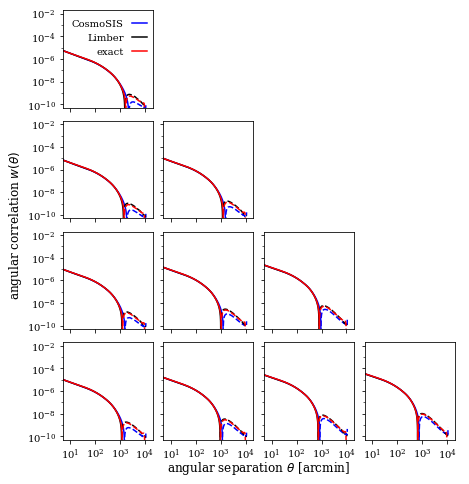

In [138]:
fig, axes = plt.subplots(4, 4, figsize=(7, 7), sharex=True, sharey=True)

for ax in axes.ravel():
    ax.axis('off')

for i, (a, b) in enumerate(zip(bin_a, bin_b)):
    ax = axes[a-1, b-1]
    ax.axis('on')
    ax.loglog(theta_arcmin, +w_csis[i], 'b', label='CosmoSIS')
    ax.loglog(theta_arcmin, -w_csis[i], '--b')
    ax.loglog(theta_arcmin, +w_limb[i], 'k', label='Limber')
    ax.loglog(theta_arcmin, -w_limb[i], '--k')
    ax.loglog(theta_arcmin, +w_geom[i], 'r', label='exact')
    ax.loglog(theta_arcmin, -w_geom[i], '--r')
    ax.set_xlim(5e0, 2e4)
    ax.set_ylim(5e-11, 2e-2)
    ax.set_xticks([1e1, 1e2, 1e3, 1e4])
    ax.set_yticks([1e-2, 1e-4, 1e-6, 1e-8, 1e-10])
    ax.set_yticks([1e-3, 1e-5, 1e-7, 1e-9], minor=True)
    ax.tick_params(axis='y', which='minor', labelcolor='none')

axes[0, 0].legend(markerfirst=False)

ax = fig.add_subplot(111, frameon=False)
ax.set_xlabel(r'angular separation $\theta$ [arcmin]', size=12)
ax.set_ylabel(r'angular correlation $w(\theta)$', size=12)
ax.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
ax.tick_params(axis='y', pad=15)

fig.tight_layout(pad=0.5)

fig.savefig('plots/w_kk.pdf', bbox_inches='tight')

plt.show()


## 5. Angular power spectra

* Convergence

In [134]:
l_limb, cl_limb = np.transpose([corfu.wtocl(theta, w, lmax=2000) for w in w_limb], (1, 0, 2))

In [135]:
l_geom, cl_geom = np.transpose([corfu.wtocl(theta, w, lmax=2000) for w in w_geom], (1, 0, 2))

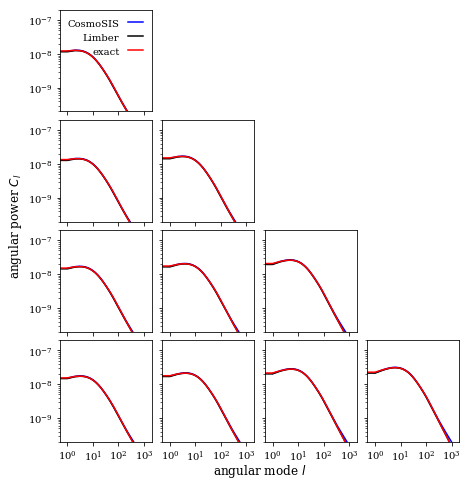

In [137]:
fig, axes = plt.subplots(4, 4, figsize=(7, 7), sharex=True, sharey=True)

for ax in axes.ravel():
    ax.axis('off')

for i, (a, b) in enumerate(zip(bin_a, bin_b)):
    ax = axes[a-1, b-1]
    ax.axis('on')
    ax.loglog(l_csis, cl_csis[i], 'b', label='CosmoSIS')
    ax.loglog(l_limb[i], cl_limb[i], 'k', label='Limber')
    ax.loglog(l_geom[i], cl_geom[i], 'r', label='exact')
    ax.set_xlim(5e-1, 2e3)
    ax.set_ylim(2e-10, 2e-7)
    ax.set_xticks([1e0, 1e1, 1e2, 1e3])
#     ax.set_yticks([1e-2, 1e-4, 1e-6, 1e-8, 1e-10])
#     ax.set_yticks([1e-3, 1e-5, 1e-7, 1e-9], minor=True)
#     ax.tick_params(axis='y', which='minor', labelcolor='none')

axes[0, 0].legend(markerfirst=False)

ax = fig.add_subplot(111, frameon=False)
ax.set_xlabel(r'angular mode $l$', size=12)
ax.set_ylabel(r'angular power $C_l$', size=12)
ax.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
ax.tick_params(axis='y', pad=12)

fig.tight_layout(pad=0.5)

fig.savefig('plots/cl_kk.pdf', bbox_inches='tight')

plt.show()

* Shear

Note: $$C_{\ell}^{\gamma \gamma} = \frac{(\ell - 1)(\ell + 2)}{\ell (\ell + 1)}C_{\ell}^{\kappa \kappa}$$

In [144]:
ell = l_geom[0]
ell_factor = (ell - 1) * (ell + 2) / (ell * (ell + 1))

/Users/c49734lf/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  


ValueError: operands could not be broadcast together with shapes (2001,) (100000,) 

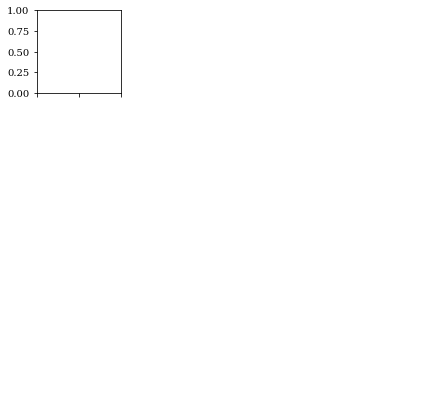

In [146]:
# plt.loglog(ell, ell_factor * cl_limb[1:], '--b', label='Limber linear')
# plt.loglog(ell, ell_factor * cl_geom[1:], '--r', label='geometric linear')
# plt.loglog(l_shear, cl_shear, 'k')
fig, axes = plt.subplots(4, 4, figsize=(7, 7), sharex=True, sharey=True)

for ax in axes.ravel():
    ax.axis('off')

for i, (a, b) in enumerate(zip(bin_a, bin_b)):
    ax = axes[a-1, b-1]
    ax.axis('on')
    ax.loglog(l_csis, ell_factor * cl_csis[i], 'b', label='CosmoSIS')
    ax.loglog(l_limb[i], ell_factor * cl_limb[i], 'k', label='Limber')
    ax.loglog(l_geom[i], ell_factor * cl_geom[i], 'r', label='exact')
    ax.set_xlim(5e-1, 2e3)
    ax.set_ylim(2e-10, 2e-7)
    ax.set_xticks([1e0, 1e1, 1e2, 1e3])
#     ax.set_yticks([1e-2, 1e-4, 1e-6, 1e-8, 1e-10])
#     ax.set_yticks([1e-3, 1e-5, 1e-7, 1e-9], minor=True)
#     ax.tick_params(axis='y', which='minor', labelcolor='none')

axes[0, 0].legend(markerfirst=False)

ax = fig.add_subplot(111, frameon=False)
ax.set_xlabel(r'angular mode $l$', size=12)
ax.set_ylabel(r'angular power $C_l$', size=12)
ax.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
ax.tick_params(axis='y', pad=12)

fig.tight_layout(pad=0.5)

# fig.savefig('plots/cl_lensing.pdf', bbox_inches='tight')

plt.show()